In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from evatuation import visualize_results

Min gross_log: 3.00
Max gross_log: 21.80
Mean gross_log: 16.81


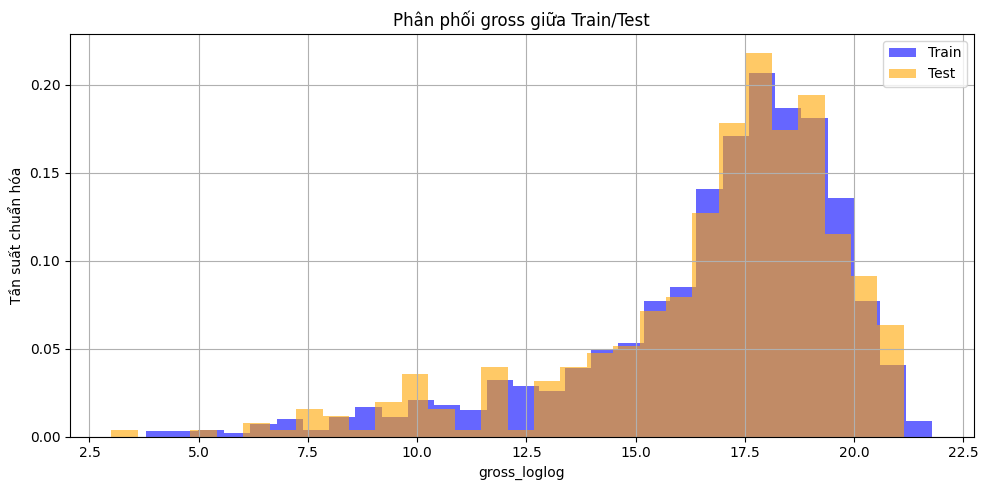

In [3]:
# Đọc dữ liệu
df = pd.read_csv("dataset/encoded_data.csv")

# Feature và target
X = df.drop(columns=['gross', 'gross_log'])
y = df['gross_log']

# Rời rạc hóa target thành 10 nhóm
y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Chia train/test với phân phối giống nhau
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X, y_binned):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Thống kê
print(f"Min gross_log: {y.min():.2f}")
print(f"Max gross_log: {y.max():.2f}")
print(f"Mean gross_log: {y.mean():.2f}")

# Vẽ phân phối
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=30, alpha=0.6, label='Train', color='blue', density=True)
plt.hist(y_test, bins=30, alpha=0.6, label='Test', color='orange', density=True)
plt.title("Phân phối gross giữa Train/Test")
plt.xlabel("gross_loglog")
plt.ylabel("Tần suất chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'subsample': [0.8, 1.0]
}

# Khởi tạo mô hình gốc
base_model = GradientBoostingRegressor(random_state=42)

# GridSearchCV với scoring là neg_root_mean_squared_error (để tìm RMSE nhỏ nhất)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Trực tiếp RMSE (>= sklearn 0.22)
    verbose=1,
    n_jobs=-1
)

# Chuẩn hóa toàn bộ dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện grid search
grid_search.fit(X_train_scaled, y_train)

# In kết quả tốt nhất
print("✅ Best Parameters from Grid Search:")
print(grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
✅ Best Parameters from Grid Search:
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}


In [5]:
# Dùng mô hình tốt nhất để thay cho model ban đầu
model = grid_search.best_estimator_

📊 Cross-validation results (on original gross scale):

📁 Fold 1
  🔹 Train:
     RMSE: 167812514.82, MSE: 28161040129256284.00, MAE: 72093701.85, MAPE: 96.09%, R²: 0.5954
  🔸 Validation:
     RMSE: 162469655.64, MSE: 26396389003693908.00, MAE: 65718317.01, MAPE: 94.98%, R²: 0.6216


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\449999005.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])


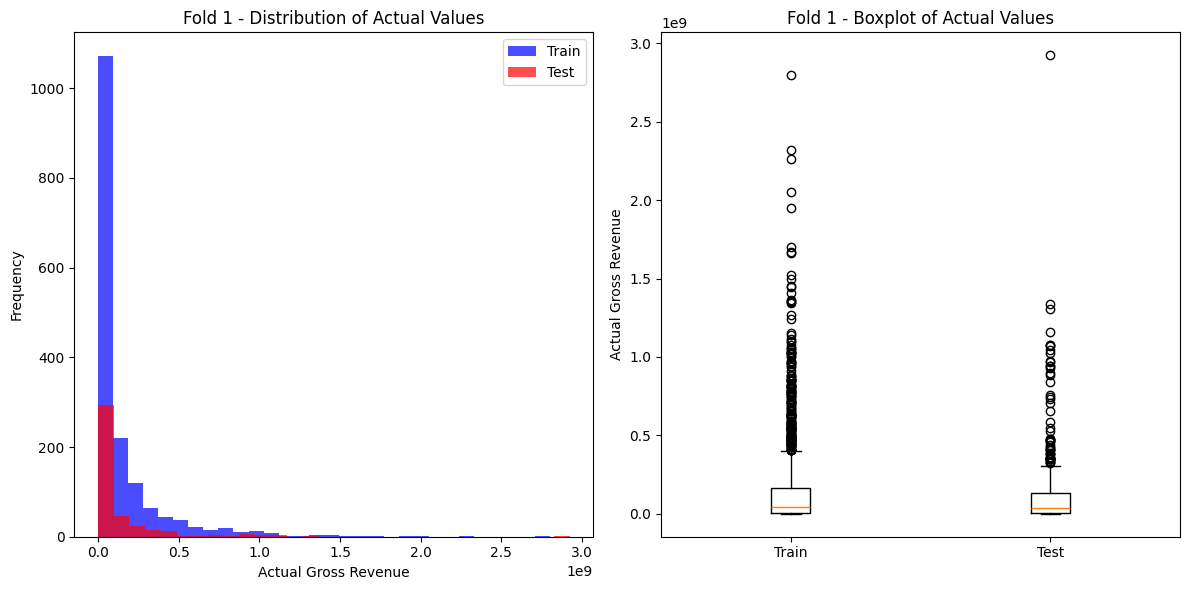

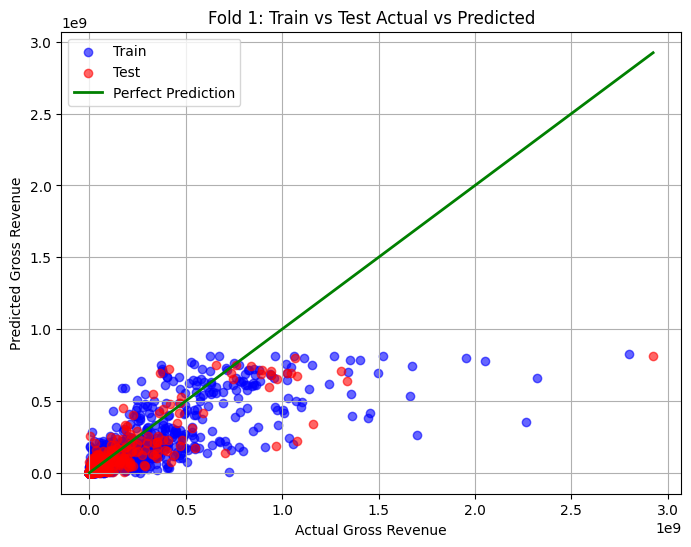


📁 Fold 2
  🔹 Train:
     RMSE: 166738352.05, MSE: 27801678045812528.00, MAE: 68559480.45, MAPE: 89.00%, R²: 0.6077
  🔸 Validation:
     RMSE: 156388967.84, MSE: 24457509261286772.00, MAE: 78808411.05, MAPE: 125.96%, R²: 0.6227


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\449999005.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])


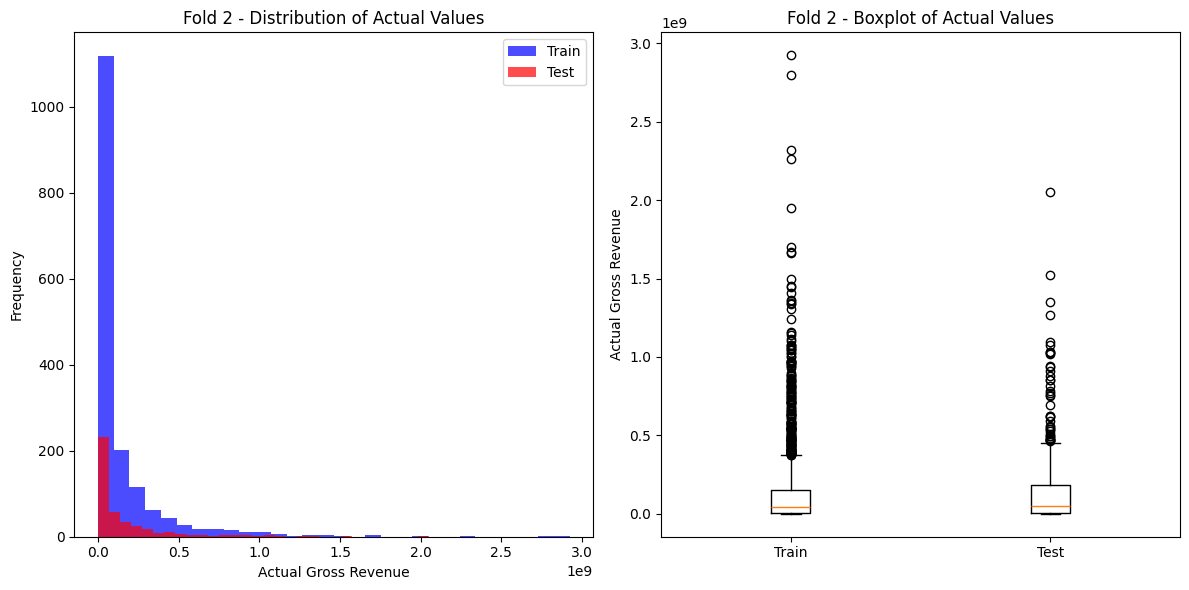

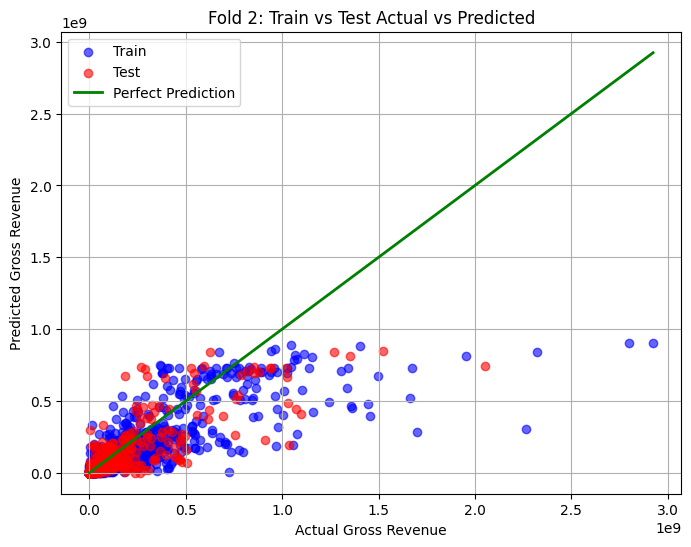


📁 Fold 3
  🔹 Train:
     RMSE: 159514466.46, MSE: 25444865008973788.00, MAE: 68002898.59, MAPE: 94.58%, R²: 0.6270
  🔸 Validation:
     RMSE: 200274226.26, MSE: 40109765702809504.00, MAE: 85564179.27, MAPE: 81.45%, R²: 0.4663


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\449999005.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])


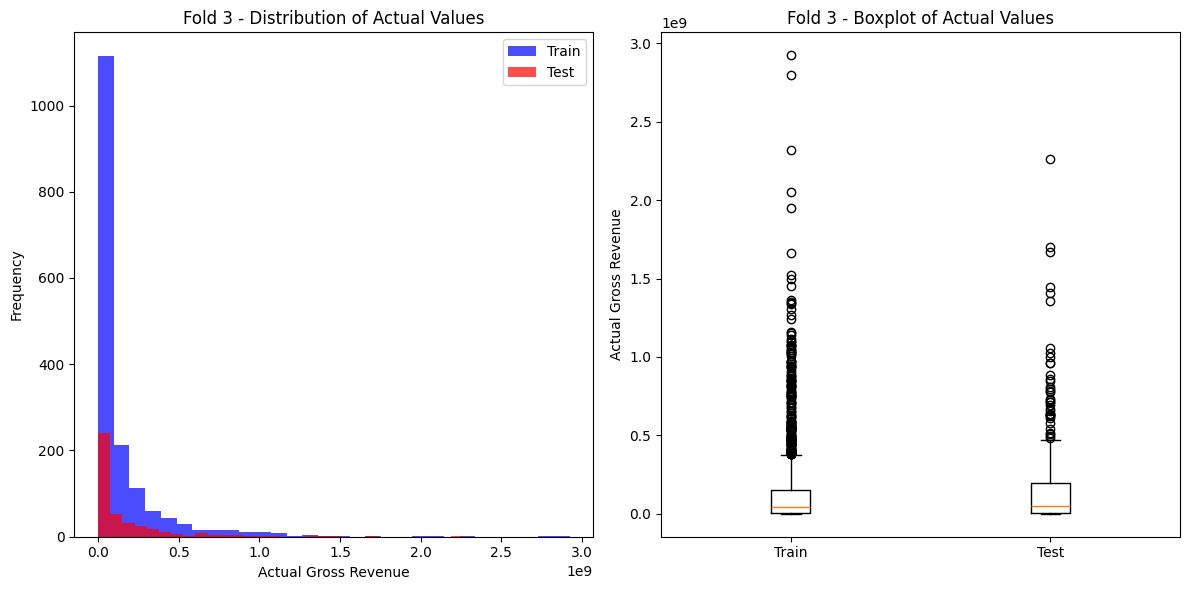

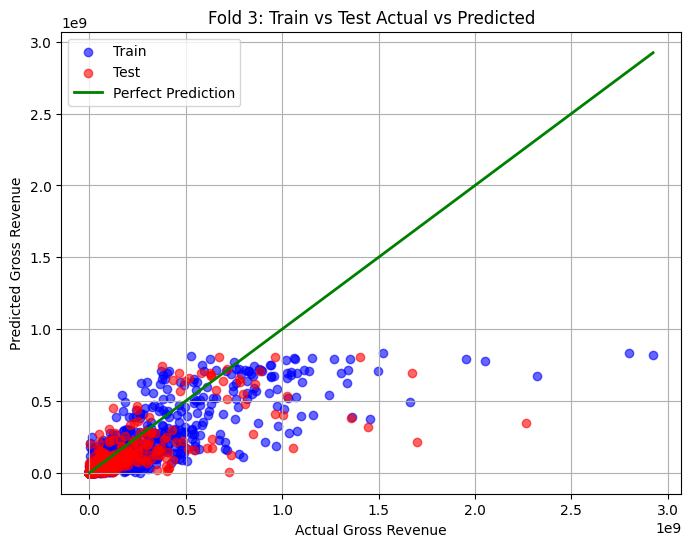


📁 Fold 4
  🔹 Train:
     RMSE: 167732204.27, MSE: 28134092350106672.00, MAE: 72225713.72, MAPE: 94.72%, R²: 0.5728
  🔸 Validation:
     RMSE: 197709301.66, MSE: 39088967961278648.00, MAE: 78393942.11, MAPE: 99.40%, R²: 0.5397


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\449999005.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])


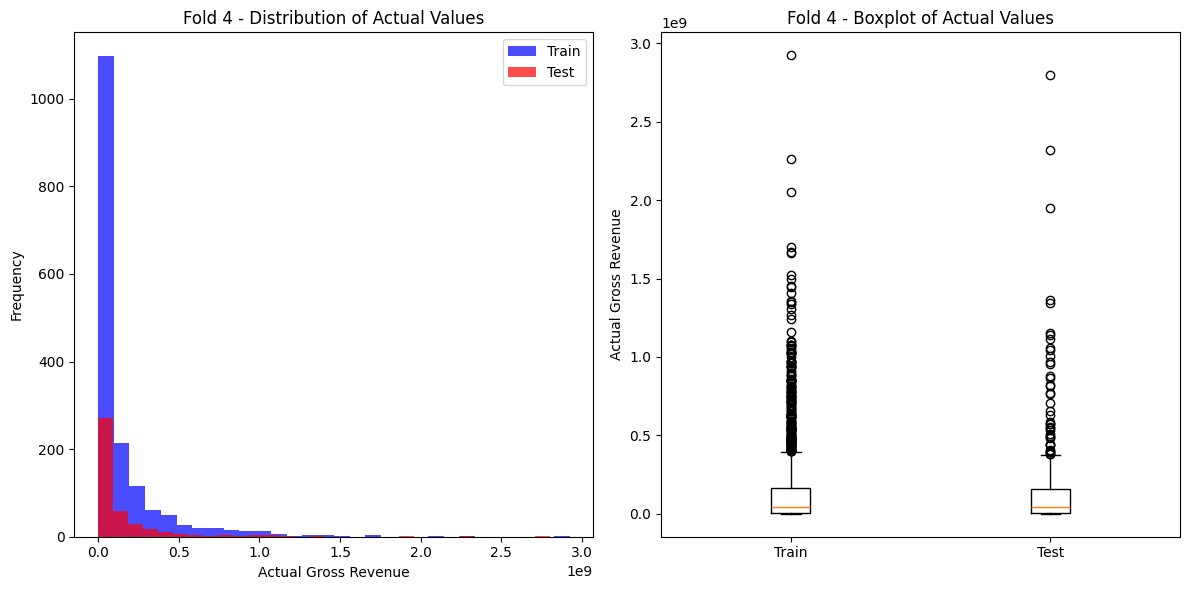

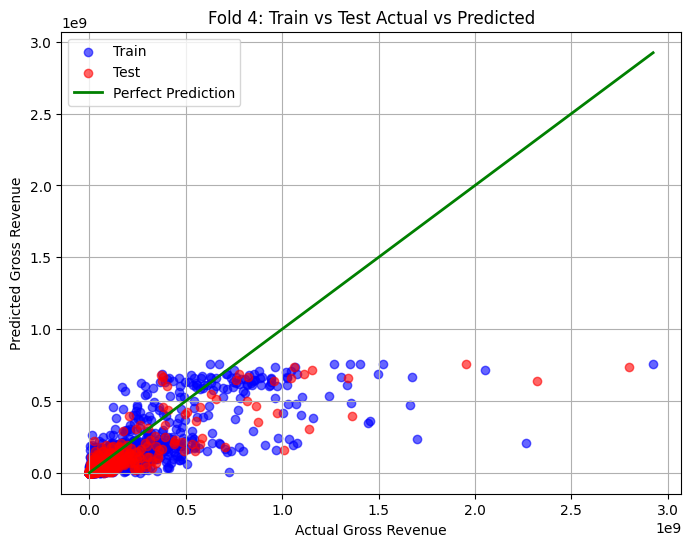


📁 Fold 5
  🔹 Train:
     RMSE: 171894283.37, MSE: 29547644653958440.00, MAE: 72461207.02, MAPE: 90.57%, R²: 0.5994
  🔸 Validation:
     RMSE: 150007990.23, MSE: 22502397134253092.00, MAE: 67437989.24, MAPE: 110.39%, R²: 0.5753


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\449999005.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])


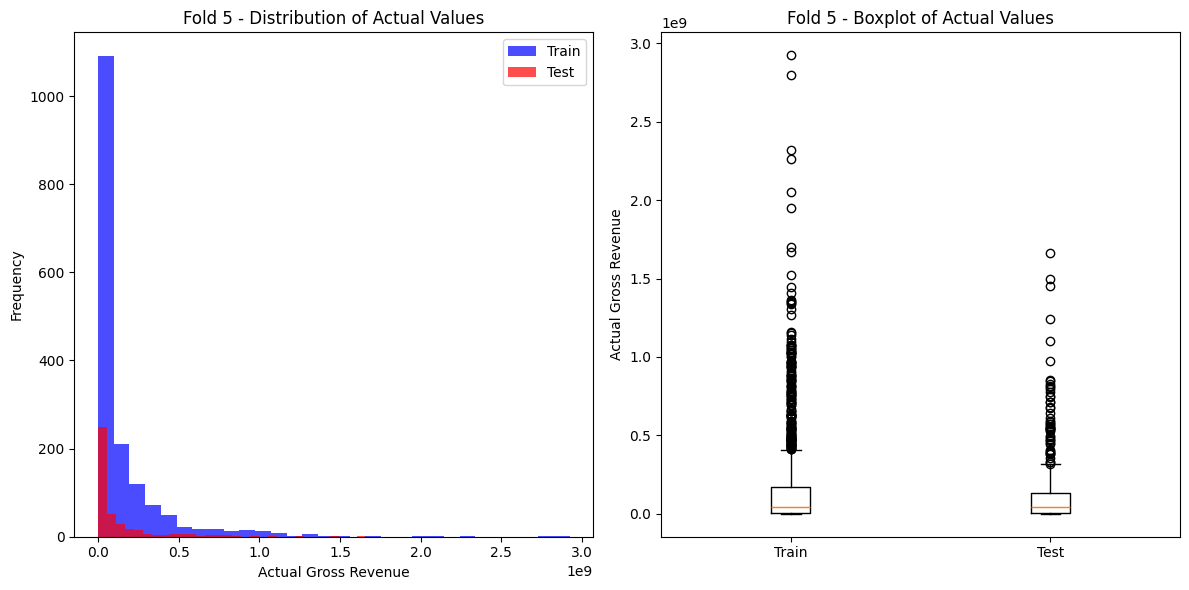

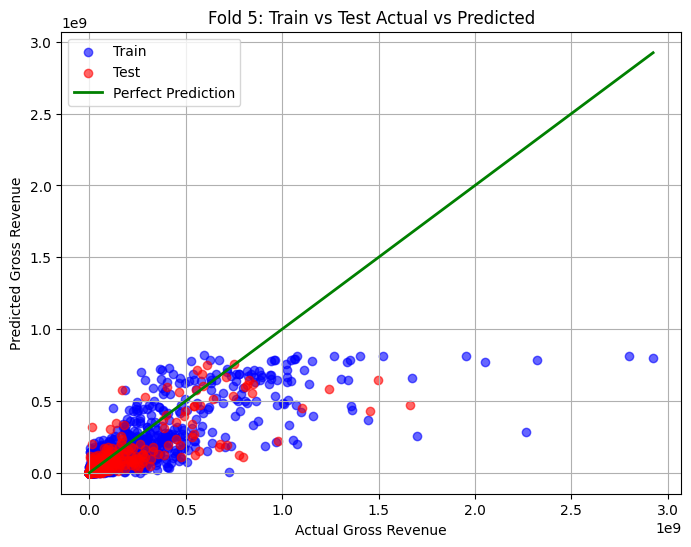

In [ ]:
# Tạo KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách lưu kết quả
rmse_list, mse_list, mae_list, mape_list, r2_list = [], [], [], [], []

print("📊 Cross-validation results (on original gross scale):")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    print(f"\n📁 Fold {fold}")

    # Tạo tập train/val
    X_train_df = X.iloc[train_idx].copy()
    X_val_df = X.iloc[val_idx].copy()
    y_train_fold_log = y.iloc[train_idx]
    y_val_fold_log = y.iloc[val_idx]

    # Chuẩn hóa
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_df)
    X_val = scaler.transform(X_val_df)

    # Fit model
    model.fit(X_train, y_train_fold_log)

    # Dự đoán trên log scale
    train_pred_log = model.predict(X_train)
    val_pred_log = model.predict(X_val)

    # Giới hạn giá trị log để tránh expm1 bị inf
    train_pred_log = np.clip(train_pred_log, a_min=None, a_max=100)
    val_pred_log = np.clip(val_pred_log, a_min=None, a_max=100)

    # Chuyển về thang đo gốc
    y_train_fold = np.expm1(y_train_fold_log)
    y_val_fold = np.expm1(y_val_fold_log)
    train_pred = np.expm1(train_pred_log)
    val_pred = np.expm1(val_pred_log)

    # Đánh giá trên tập train
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, train_pred))
    mse_train = mean_squared_error(y_train_fold, train_pred)
    mae_train = mean_absolute_error(y_train_fold, train_pred)
    mape_train = mean_absolute_percentage_error(y_train_fold[y_train_fold > 1e6], train_pred[y_train_fold > 1e6])
    r2_train = r2_score(y_train_fold, train_pred)

    # Đánh giá trên tập validation
    rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
    mse = mean_squared_error(y_val_fold, val_pred)
    mae = mean_absolute_error(y_val_fold, val_pred)
    mape = mean_absolute_percentage_error(y_val_fold[y_val_fold > 1e6], val_pred[y_val_fold > 1e6])
    r2 = r2_score(y_val_fold, val_pred)

    # Lưu kết quả test
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    # In kết quả
    print("  🔹 Train:")
    print(f"     RMSE: {rmse_train:.2f}, MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, MAPE: {mape_train*100:.2f}%, R²: {r2_train:.4f}")
    print("  🔸 Validation:")
    print(f"     RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape*100:.2f}%, R²: {r2:.4f}")

    # Biểu đồ phân phối giá trị thực tế cho Train và Test
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_train_fold, bins=30, color='blue', alpha=0.7, label="Train")
    plt.hist(y_val_fold, bins=30, color='red', alpha=0.7, label="Test")
    plt.title(f"Fold {fold} - Distribution of Actual Values")
    plt.xlabel("Actual Gross Revenue")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([y_train_fold, y_val_fold], labels=["Train", "Test"])
    plt.title(f"Fold {fold} - Boxplot of Actual Values")
    plt.ylabel("Actual Gross Revenue")
    plt.tight_layout()
    plt.show()

    # Biểu đồ Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_fold, train_pred, color='blue', label='Train', alpha=0.6)
    plt.scatter(y_val_fold, val_pred, color='red', label='Test', alpha=0.6)
    plt.plot([min(y_train_fold.min(), y_val_fold.min()), max(y_train_fold.max(), y_val_fold.max())],
             [min(y_train_fold.min(), y_val_fold.min()), max(y_train_fold.max(), y_val_fold.max())],
             color='green', lw=2, label="Perfect Prediction")
    plt.title(f"Fold {fold}: Train vs Test Actual vs Predicted")
    plt.xlabel("Actual Gross Revenue")
    plt.ylabel("Predicted Gross Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\2451885376.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
d:\Thanh\TLHT\HK6\KHDL\movie-analyst\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


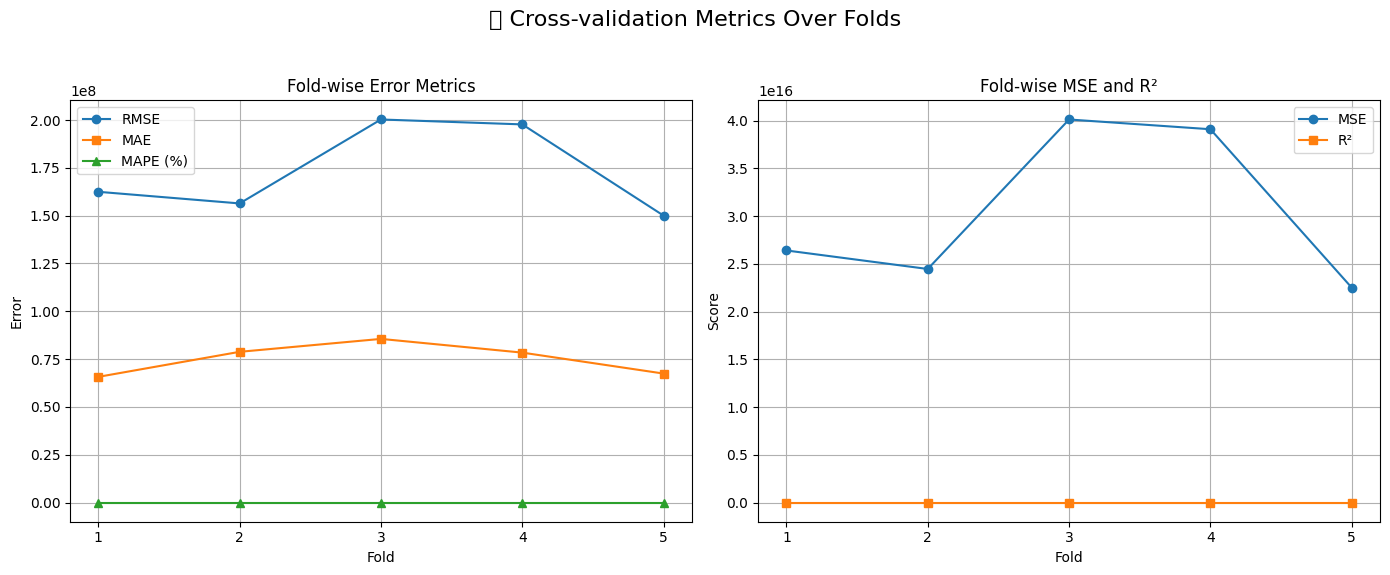

C:\Users\nptha\AppData\Local\Temp\ipykernel_6936\2451885376.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Thanh\TLHT\HK6\KHDL\movie-analyst\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


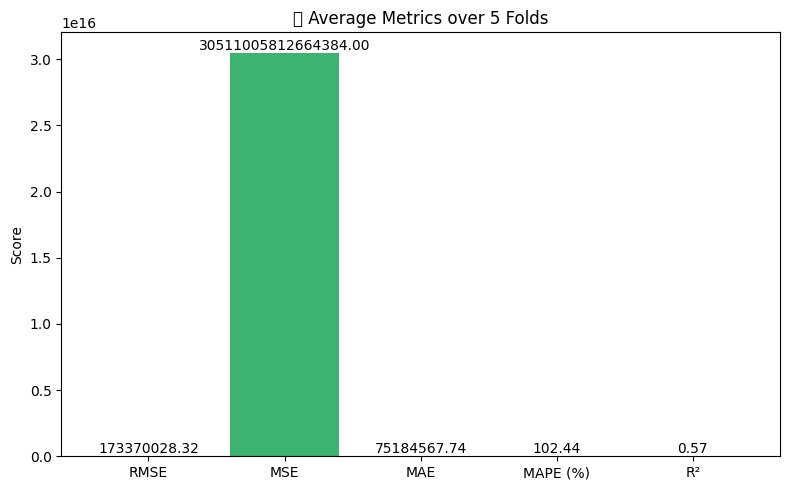


📈 Average Cross-validation Performance (gross):
Avg RMSE: 173370028.32
Avg MSE:  30511005812664384.00
Avg MAE:  75184567.74
Avg MAPE: 102.44%
Avg R²:   0.5651


In [7]:
# 🔍 Trực quan hóa kết quả từng fold
folds = np.arange(1, len(rmse_list)+1)

plt.figure(figsize=(14, 6))

# Subplot 1: RMSE, MAE, MAPE
plt.subplot(1, 2, 1)
plt.plot(folds, rmse_list, marker='o', label='RMSE')
plt.plot(folds, mae_list, marker='s', label='MAE')
plt.plot(folds, np.array(mape_list)*100, marker='^', label='MAPE (%)')
plt.title("Fold-wise Error Metrics")
plt.xlabel("Fold")
plt.ylabel("Error")
plt.xticks(folds)
plt.grid(True)
plt.legend()

# Subplot 2: MSE & R2
plt.subplot(1, 2, 2)
plt.plot(folds, mse_list, marker='o', label='MSE')
plt.plot(folds, r2_list, marker='s', label='R²')
plt.title("Fold-wise MSE and R²")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.xticks(folds)
plt.grid(True)
plt.legend()

plt.suptitle("📈 Cross-validation Metrics Over Folds", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 📊 Biểu đồ cột tổng kết trung bình
metrics = ["RMSE", "MSE", "MAE", "MAPE (%)", "R²"]
avg_scores = [
    np.mean(rmse_list),
    np.mean(mse_list),
    np.mean(mae_list),
    np.mean(mape_list) * 100,
    np.mean(r2_list)
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, avg_scores, color='mediumseagreen')
plt.title("📊 Average Metrics over 5 Folds")
plt.ylabel("Score")
for bar, val in zip(bars, avg_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# In kết quả trung bình
print("\n📈 Average Cross-validation Performance (gross):")
print(f"Avg RMSE: {np.mean(rmse_list):.2f}")
print(f"Avg MSE:  {np.mean(mse_list):.2f}")
print(f"Avg MAE:  {np.mean(mae_list):.2f}")
print(f"Avg MAPE: {np.mean(mape_list)*100:.2f}%")
print(f"Avg R²:   {np.mean(r2_list):.4f}")


In [9]:
# Huấn luyện mô hình với dữ liệu huấn luyện
model.fit(X_train_scaled, y_train)

# Dự đoán trên log scale
train_pred_log = model.predict(X_train_scaled)
test_pred_log = model.predict(X_test_scaled)

# Chuyển log về giá trị gốc
train_pred = np.expm1(train_pred_log)
test_pred = np.expm1(test_pred_log)

# Chuyển y_train/y_test về giá trị gốc
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

# Tính các chỉ số gốc (không log)
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_pred))

train_r2 = r2_score(y_train_original, train_pred)
test_r2 = r2_score(y_test_original, test_pred)

train_mae = mean_absolute_error(y_train_original, train_pred)
test_mae = mean_absolute_error(y_test_original, test_pred)

# Lọc để tính MAPE hợp lý (chỉ xét gross > 1 triệu)
mask_train = y_train_original > 0 // 100e6
mask_test = y_test_original > 0 //100e6

train_mape = mean_absolute_percentage_error(
    y_train_original[mask_train], train_pred[mask_train])
test_mape = mean_absolute_percentage_error(
    y_test_original[mask_test], test_pred[mask_test])

# In kết quả
print("📈 Đánh giá mô hình trên dữ liệu gốc (gross):")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAPE (gross > $1M): {train_mape*100:.2f}%")
print(f"Test MAPE (gross > $1M): {test_mape*100:.2f}%")


📈 Đánh giá mô hình trên dữ liệu gốc (gross):
Training RMSE: 171878273.78
Test RMSE: 142106897.77
Training MAE: 71092353.54
Test MAE: 71285865.42
Training R²: 0.5927
Test R²: 0.6531
Training MAPE (gross > $1M): 3977.52%
Test MAPE (gross > $1M): 9279.21%
